# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `10`
* Students: `Fluhr Hugo, Donzier Paul, Delagoums Frédéric, Cionca Alexandre`
* Dataset: `IMDb, tmdb_5000_movies.csv`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [2]:
# We load both datasets, credits contains the casts of the movies and movies contains movie features
credits=pd.read_csv('../dataset/TMDb/tmdb_5000_credits.csv')
movies=pd.read_csv('../dataset/TMDb/tmdb_5000_movies.csv')

# The columns cast and crew of the dataset credits are strings, we use json.loads to convert into dict
json_columns = ['cast', 'crew']
for column in json_columns:
     credits[column] = credits[column].apply(json.loads)


In [3]:
# DATA FILTERING

joined=credits.join(movies, rsuffix='other')
joined=joined.drop(columns=['budget','overview','original_language','vote_average','crew',
                            'popularity','genres','homepage','id','keywords','original_title',
                            'production_companies','production_countries','release_date',
                            'revenue','runtime','spoken_languages','tagline','titleother'])

#To reduce the dataset, we filter unreleased movies and movies with a vote count inferior to 100
joined=joined[joined.status=='Released']
joined=joined[joined.vote_count >=100]
joined=joined.drop(columns=['vote_count','status'])
# Reseting the index after filtering
joined=joined.reset_index(drop=True)
len(joined)

3162

In [5]:
#Creating empty column which will be filled with the id of the actors present in each movie
joined['actors_id']=""

for i in range(len(joined.title)):
    strs=[]
    for ii in range(len(joined.cast[i])):
        strs.append(joined.cast[i][ii]['id'])#.loc[:,('cast',i,ii)]
    joined.actors_id[i]=np.asarray(strs)

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [6]:
# Your code here

n_nodes = len(joined) # the number of nodes in the network

adjacency=np.zeros((n_nodes,n_nodes), dtype=float)

# The adjacency matrice contains the number of common actors for each pair of nodes (movies)
# The matrice is set to be symmetric since the relation of shared actor is undirected
for i in range(len(joined.index)):
    for ii in range(i+1,(len(joined.index))):
            adjacency[i,ii]=adjacency[ii,i]=len(np.intersect1d(joined.actors_id[i],joined.actors_id[ii]))
            
# We normalize by the maximum number of shared actors between two movies of the dataset
adjacency = np.divide(adjacency,adjacency.max());

In [7]:
# We see from the adjacency matrix that there are some movies that don't have any connections to any other movies,
# these nodes don't present any interest to us so we remove them from both the dataframe and the adjacency matrix
i=0
while i < len(adjacency):
    if not any(adjacency[i]):
        adjacency = np.delete(adjacency, i, 0)
        adjacency = np.delete(adjacency, i, 1)
        joined=joined.drop([i])
        joined=joined.reset_index(drop=True)
    else:
        i+=1
        
# We need to update n_nodes since we have dropped some movies

n_nodes=len(adjacency)

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

In [10]:
#adjacency[:10,:10]

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [11]:
# We find in the first lecture of the course the expression of L_max, the maximum number of links for a fully connected graph.
# L max is equal to the number of distinct pair of nodes present in the graph.
L_max=int(n_nodes*(n_nodes-1)/2)
print(L_max)

## to compute L, we need to count how many non-zero elements there are in adjacency matrix
## divide by 2 since undirected graph
L=0
for i in range(adjacency.shape[0]):
    for ii in range(i,adjacency.shape[1]):
        L+=(adjacency[i][ii]!=0)
print(L)

4921953
163621


L_max for our graph which has 3138 nodes is equal to 4'921'953

In our graph, there are 163'621 links

We find a density: L/L_max = 0.033, showing that our graph, much like many real graphs, is sparse

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

Our graph is undirected. The links between movies represent the number of actors they share which is an undirected relation.

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [12]:
# Your code here.
movies.to_csv('saved_features', sep='\t', encoding='utf-8')
np.save('saved_adjacency',adjacency)

### Question 4

Are the edges of your graph weighted?

Yes, the edges are weigthed, the weigth corresponds to the number of shared actors.
Since we have normalized the weigths, they represent a proportion of how many actors two movies share divided by the maximum of shared actors between two movies found in the dataset.

### Question 5

What is the degree distibution of your network? 

In [13]:
# We create an array containing the degree of each node, the degree being the sum of the weights.
degree = np.sum(adjacency,0)

# Here we verify that there are as many elements in the degree array as there are nodes (movies) in the graph.
assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

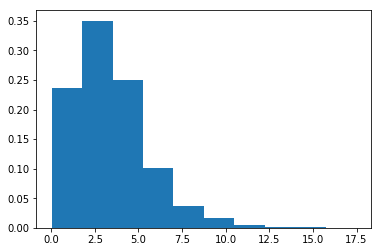

In [14]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [15]:
# Your code here.
average_deg=np.divide(np.sum(degree),n_nodes)
print(average_deg)

3.3771979154950618


### Question 6

Comment on the degree distribution of your network.

**Your answer here.**

We see from the degree histogram that

In [16]:
# We create an unweighted version ot the adjacency matrix which we will use in several of the following questions.
unw_adj=np.where(adjacency != 0, 1, 0)

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [17]:
# We implement a version of the BFS algorithm in an additional function that we will need for
# both questions 7 and 8

def bfs(adjacency, source_node):
    # explored is an array where explored[a_certain_node]= 0 when this a_certain_node has
    # not been visited or = 1 when this a_certain_node has been visited
    n_nodes=len(adjacency)
    explored=np.full(n_nodes,0)
    # store nodes to explore in a second list
    to_explore = [source_node]
    
    # the source node is already explored
    explored[source_node] = 1  
    
    # stay in loop while there are still nodes to explore
    while to_explore:
       # pop first node frome the queue and add it to to the explored nodes
        current_node = to_explore.pop(0)
    #    print('cn:',current_node)
        explored[current_node] = 1
        ##print(explored)
        # copy the line of the matrix corresponding to the current node to see its connections
    #    print('adj de cn:',adjacency[current_node])
        neighbours = np.argwhere(adjacency[current_node]).flatten()
    #    print('voisins de :',current_node,'=',neighbours)
        # set the neighbours of current_node to be explored

        for i in range(len(neighbours)):
            if not explored[neighbours[i]]:
                to_explore.append(neighbours[i])
                explored[neighbours[i]]=1
    #        print('i:',i)
    
    return explored   

In [18]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    
    # Your code here.
    
    # We call the previously implemented bfs function and check if the number of reached starting from the first
    # node is equal to the number of nodes in the graph
    n_nodes=len(adjacency)
    connected = (len(np.argwhere(bfs(adjacency,0)))==n_nodes)
    
    return connected

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [19]:
connected_graph(adjacency)

True

### Question 8

Write a function that extracts the connected components of a graph.

In [20]:
def no_zero(matrix):
    
    i=0
    while i < len(matrix):
        if not any(matrix[i]):
            matrix = np.delete(matrix, i, 0)
            matrix = np.delete(matrix, i, 1)
        else:
            i+=1
    
    
    return matrix

In [21]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Your code here.
    n_nodes=len(adjacency)
    components=[]
    # We declare an array of size n_nodes which contains for each node its component index,
    # e.g. to which component it belongs
    comp_idx=np.full(n_nodes,0)
    component_label=1
    
   
    while len(np.argwhere(comp_idx))<n_nodes:
        comp_idx +=component_label*bfs(adjacency,np.argwhere(comp_idx==0)[0,0])
        component_label+=1
        
    for i in range(1,component_label):
        matrix=adjacency@np.diag(comp_idx == i)
        matrix=no_zero(matrix)
        components.append(matrix)
    
    return components

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [22]:
# Your code here.
mat = np.array([[0, 1, 0, 1, 0],
                [1, 0, 0, 0, 0],
                [0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0] ])

comps=find_components(adjacency)

### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [23]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    # 
    # Your code here.
    
    # Firstly, we transform the matrix to and unweighted one
    adjacency=np.where(adjacency != 0, 1, 0)
    n_nodes=adjacency.shape[0]
    #print(n_nodes)
    shortest_path_lengths=np.full(n_nodes,np.inf)
    previous_node=np.full(n_nodes,None)
    shortest_path_lengths[source]=0
    
    unvis_nodes=list(range(n_nodes))
    #del unvis_nodes[0] 
    #print(unvis_nodes)
    
    #while there are nodes that we haven't visited
    while unvis_nodes:
        dist_min=np.inf
        current_node=None
        
        #search for the unvisited node with the shortest shortes_path_length
        for i in range(len(unvis_nodes)):
            if (shortest_path_lengths[unvis_nodes[i]]<dist_min): 
                #print('spl:',shortest_path_lengths[i],'dist_min:',dist_min)
                dist_min=shortest_path_lengths[unvis_nodes[i]]
                #print('salut')
                current_node=unvis_nodes[i]
        # if every node of unvis_nodes has infinite distance in spl, hence it is not in the connected
        # component, we arbitrarly take the first of the unvis_nodes
        if current_node==None:
            #print('salut')
            current_node=unvis_nodes[0]
        # current_node=np.argmin[shortest_path_lengths]
        # print(current_node)
        
        unvis_nodes.remove(current_node) #use del ?,   
        # print(unvis_nodes)
        unvis_neighbours=np.intersect1d(np.argwhere(adjacency[current_node]),np.asarray(unvis_nodes))
        #print('voisins:',np.argwhere(adjacency[current_node]))
        for i in range(len(unvis_neighbours)):
            alt_path=shortest_path_lengths[current_node]+adjacency[current_node][unvis_neighbours[i]]
            #print('alt_path:',alt_path,'node:',neighbours[i])
            #print('spl:',shortest_path_lengths[neighbours[i]])
            if (shortest_path_lengths[unvis_neighbours[i]]>alt_path):
                shortest_path_lengths[unvis_neighbours[i]]=alt_path
                previous_node[unvis_neighbours[i]]=current_node
            #print('here:',current_node)
        #if len(unvis_nodes)<7:
        #print(shortest_path_lengths)           
    
    return shortest_path_lengths

In [24]:
spl=compute_shortest_path_lengths(adjacency,0)
#len(np.where(adjacency[0]))
np.argwhere(spl==np.inf)

array([], shape=(0, 1), dtype=int64)

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [25]:
# Your code here.
diameter=0

for i in range(n_nodes):
    diameter=max(max(compute_shortest_path_lengths(adjacency,i)),diameter)
print(diameter)

6.0


### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [26]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    # Your code here.
    adj_bin=np.where(adjacency != 0, 1, 0)
    #print(adj_bin[:10,:10])
    pow_adj=adj_bin
    ##compute adj_bin to the power length
    if length==1:
        n_paths=adj_bin[source,target]
    else:    
        for i in range(length-1):
            pow_adj=np.matmul(pow_adj,adj_bin)
        n_paths=pow_adj[source,target]   
    
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [27]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0
4
819
10
344391


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [52]:
# Your code here.
## sum elements of A^3 divided by 2

adj_carr=np.matmul(adj_bin,adj_bin)
adj_cub=np.matmul(adj_carr,adj_bin)
adj_cub[:15,:15]
sum=np.int64((np.sum(np.sum(np.int64(adj_cub)))))/2
sum


3364928061.0

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [29]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    # Your code here.
    Li = 0 # number of links between the neighbors of node on which we want to calculate the clustering coeff.
    ki_list = [] # list of neighbors of node on which we want to calculate the clustering coeff.

    for i in range(len(adjacency)):
        if (adjacency[node,i] != 0 and i != node): # find neighboring nodes
            ki_list.append(i) # store neighboring nodes
            
    # if the number of neighbors is equal to or less than 1, the clustering coefficient is 0 :       
    if (len(ki_list))<=1:
        return 0.0
    else :
        for i in range(len(ki_list)): # for every neighbors
            for j in ki_list:
                if ((adjacency[ki_list[i],j] != 0) and (j in ki_list[i:])): # count every links between the neighbors only once
                    Li += 1 # no difference in the execution when giving unweighted or weighted adjacency matrix
        clustering_coefficient = (2*Li)/(len(ki_list)*(len(ki_list) - 1)) # formula
    
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [34]:
average_clustering_coeff = 0.
for i in range(n_nodes):
    average_clustering_coeff += compute_clustering_coefficient(adjacency, i)/n_nodes

In [36]:
graph= nx.from_numpy_array(adjacency)

In [ ]:
nx.draw_spectral(graph)

In [ ]:
nx.draw_spring(graph)

In [37]:
nx.write_gexf(graph,'movies_graph.gexf')

In [35]:
print(average_clustering_coeff)

0.2143334404916158
